In [1]:
paths = [".."]
import sys
for path in paths:
    if path not in sys.path:
        sys.path.append(path)
from nf_slam.lidar_dataset_loader import LidarDatasetLoader, LidarDatasetLoaderConfig
from nf_slam.space_hashing_mapping.map_model import MapModelConfig
from nf_slam.space_hashing_mapping.mlp_model import MLPModel
from nf_slam.space_hashing_mapping.mapping import LearningConfig, OptimizerConfig, MapBuilder
from nf_slam.plotting_utils import show_points, plot_nf_with_scans, plot_optimization_result
from nf_slam.tracking.tracking import OptimizePositionConfig, PositionOptimizer
import matplotlib.pyplot as plt
import jax.numpy as jnp

ROS is not sourced. To enable ROS features, please source it


# Load data

In [2]:
lidar_dataset_loader_config = LidarDatasetLoaderConfig(
    maximal_token_length=180,
    minimal_angle=90.,
    maximal_angle=90.,
    maximal_distance=10.
)
dataset_loader = LidarDatasetLoader(lidar_dataset_loader_config)

In [3]:
datafile = "/home/mikhail/Downloads/intel.gfs(4).log" 
datafile = "/home/mikhail/Downloads/intel.log"
laser_data_list = dataset_loader.load(datafile)

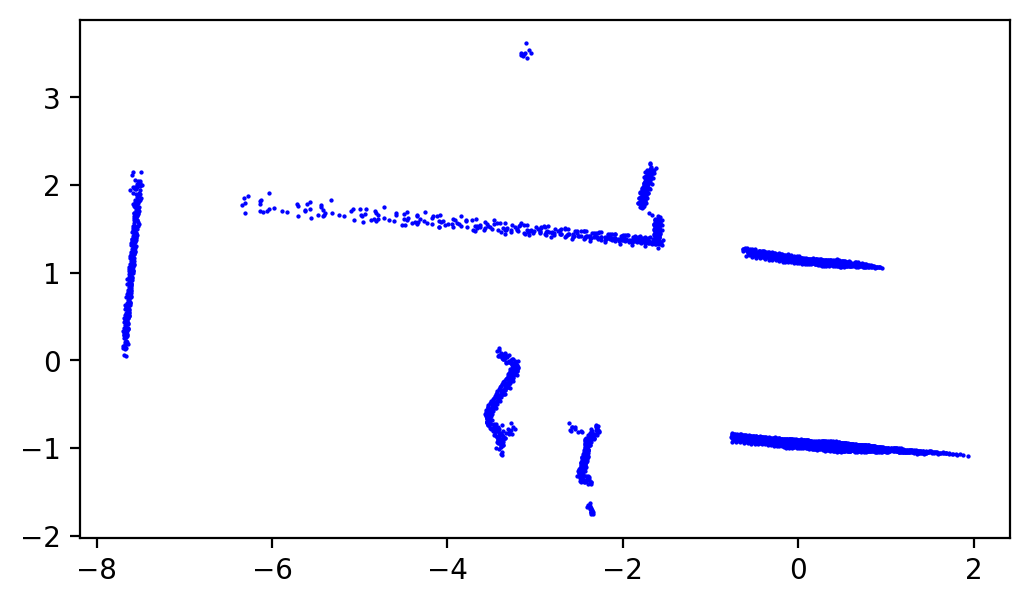

In [4]:
plt.figure(dpi=200)
show_points(laser_data_list[200:220], c="blue");

# Mapping

In [5]:
map_model_config = MapModelConfig(
    minimal_depth=0.05,
    maximal_depth=10,
    bins_count=60,
    density_scale=0.05,
    variance_weight=0.1,
    F=32,
    L=4,
    T=2048,
    min_log_resolution=-4,
    max_log_resolution=1.
)
learning_config = LearningConfig(
    iterations=100,
    variable_optimizer_config=OptimizerConfig(
        learning_rate=2e-2,
        beta1=0.9,
        beta2=0.99,
        eps=1e-15,
        weight_decay=1e-6,
    ),
    hashtable_optimizer_config=OptimizerConfig(
        learning_rate=2e-2,
        beta1=0.9,
        beta2=0.99,
        eps=1e-15,
        weight_decay=0,
    )
)
mlp_model = MLPModel()
map_builder = MapBuilder(learning_config, map_model_config, mlp_model)

learning_index = 200
laser_data = laser_data_list[learning_index]
map_position = jnp.array(laser_data.odometry_position.as_vec())
map_builder_result = map_builder.build_map(laser_data, map_position)

Compilation take 4.773686408996582 s


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 20.28it/s]


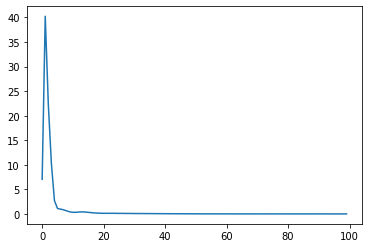

In [6]:
plt.plot(map_builder_result.loss_history)

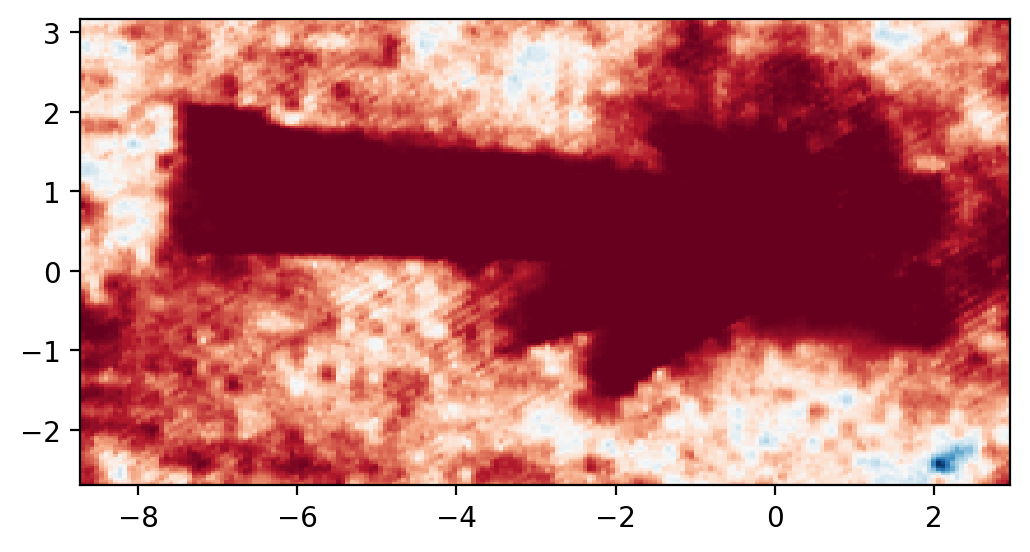

In [7]:
plt.figure(dpi=200)
plot_nf_with_scans(laser_data_list[learning_index:learning_index + 1], map_builder_result.map_model, mlp_model)

# Find position

In [43]:
position_optimization_config = OptimizePositionConfig(
    iterations=100,
    init_hessian = jnp.diag(jnp.array([2000, 2000, 2000])),
    maximal_clip_norm = 20,
    beta1 = 0.7,
    beta2 = 0.4,
    hessian_adder = jnp.diag(jnp.array([200, 200, 20]))
)
position_optimizer = PositionOptimizer(position_optimization_config, map_model_config, mlp_model)

In [68]:
init_position = jnp.array([0, -1, 2.7])
laser_data = laser_data_list[learning_index + 1]
init_position = jnp.array(laser_data_list[learning_index].odometry_position.as_vec())
find_position_result = position_optimizer.find_position(laser_data, map_builder_result.map_model, init_position)

100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 18.31it/s]


In [69]:
print(init_position)
print(find_position_result.optimized_position)
print(jnp.array(laser_data.odometry_position.as_vec()))

[ 0.704     0.027    -2.288594]
[ 0.7065765   0.02555961 -2.3520207 ]
[ 0.705     0.028    -2.337758]


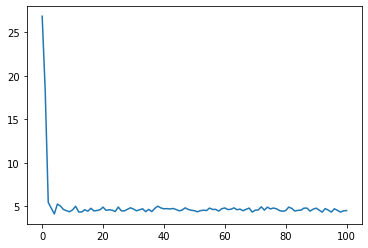

In [72]:
plt.plot(find_position_result.loss_history)

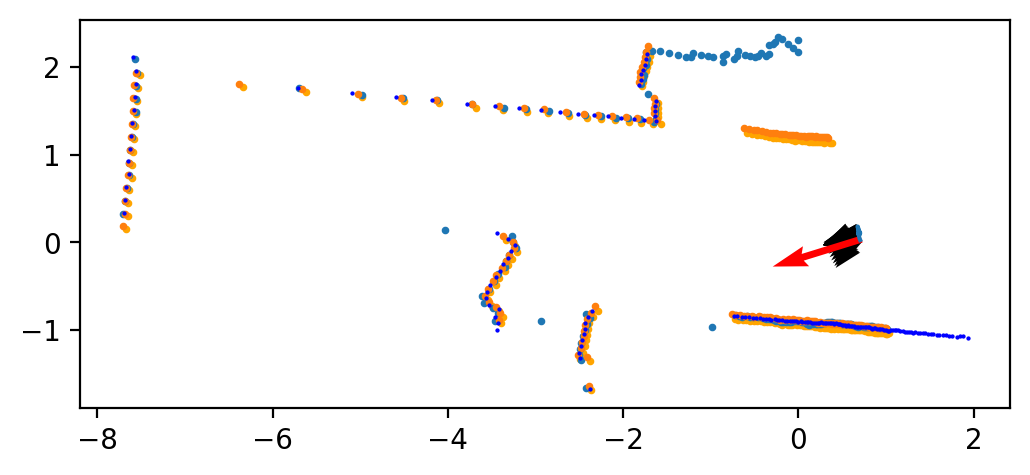

In [66]:
plot_optimization_result(laser_data, map_model_config, map_builder_result.map_model, mlp_model, 
                         find_position_result.optimized_position, find_position_result.position_history)
show_points(laser_data_list[200:201], c="blue");

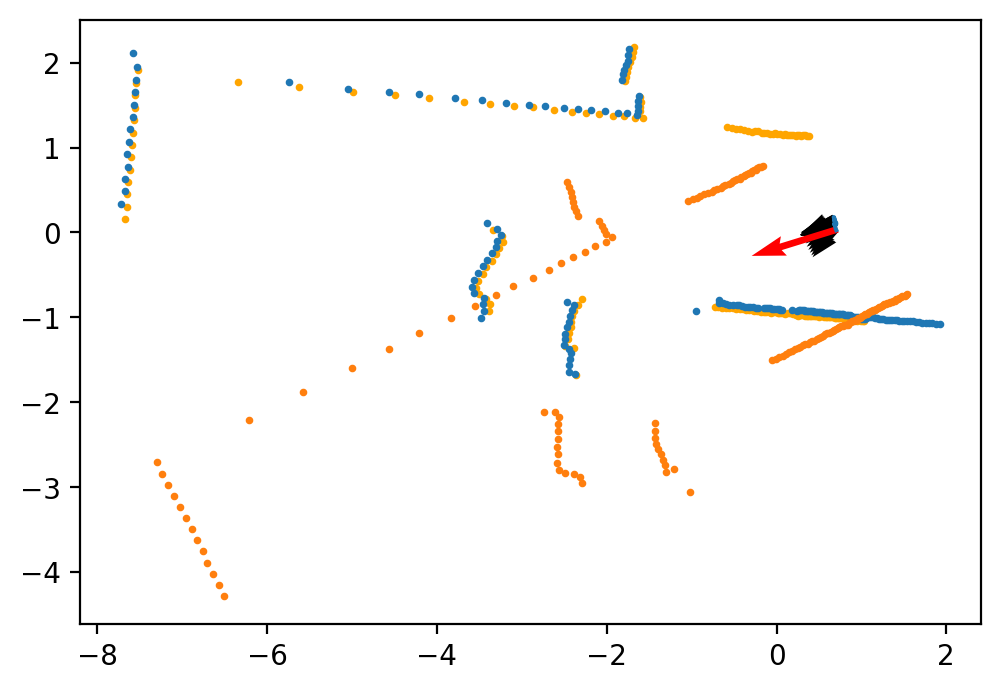

In [67]:
plot_optimization_result(laser_data, map_model_config, map_builder_result.map_model, mlp_model, 
                         init_position, find_position_result.position_history)

# Odometry